# Cubesat Design

In [1]:
# This scrip is for the calculation to set the cubesat configuration.
# Imports
import math
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
from numpy import pi
from scipy.integrate import solve_ivp

# Variáveis globais
mu_Terra = 3.98600441e+014 # [m^3/s**2]
raioEquatorialTerra = 6.378136e+6 # [m]
raioPolarTerra = 6.356753e+6 # [m]
sequencia_rotacao = np.array([3, 2, 1])
m2ft = 3.2808399
kg2slug = 0.06852177


# Função para calcular a derivada da velocidade angular
def odeDinamica(t, w, J, T_B):
    Y_dot = np.zeros(3)
    Y_dot[0] = (1/J[0, 0]) * ((J[1, 1] - J[2, 2]) * w[1] * w[2] + T_B[0])
    Y_dot[1] = (1/J[1, 1]) * ((J[2, 2] - J[0, 0]) * w[0] * w[2] + T_B[1])
    Y_dot[2] = (1/J[2, 2]) * ((J[0, 0] - J[1, 1]) * w[0] * w[1] + T_B[2])
    return Y_dot

# Função principal
def Sadt(J, w_B_I_B, T_res, t1, t2):
    cond_init = w_B_I_B
    conf_ode = {'rtol': 1e-6, 'atol': 1e-6}
    sol = solve_ivp(odeDinamica, [t1, t2], cond_init, t_eval=[t1, t2], args=(J, T_res), **conf_ode)
    Y = sol.y
    new_w_B_I_B = Y[:, -1]  # Pegar o último valor calculado
    

def  q2eulang(q):
    C = q2C(q)
    pitch = -np.asin(C[0][2])
    if ((pitch>pi/2) or (pitch<=-pi/2)):
        pitch = pi-pitch

    yaw = np.arctan2(C[0][1], C[0][0])
    roll = np.arctan2(C[1][2], C[2][2])
    eulAng = [roll, pitch, yaw]
    return eulAng

# Definir a função que calcula a derivada dos quaternions
def edoCinematica(t, Y, w_B_O_B):
    M = np.array([
        [0, w_B_O_B[2], -w_B_O_B[1], w_B_O_B[0]],
        [-w_B_O_B[2], 0, w_B_O_B[0], w_B_O_B[1]],
        [w_B_O_B[1], -w_B_O_B[0], 0, w_B_O_B[2]],
        [-w_B_O_B[0], -w_B_O_B[1], -w_B_O_B[2], 0]
    ])
    Y_dot = 0.5 * np.dot(M, Y)
    return Y_dot

# Definir a função principal
def Sdq_dtdt(q, w_B_O_B, t1, t2):
    cond_init = np.transpose(q)
    conf_ode = {'rtol': 1e-6, 'atol': 1e-6}
    sol = solve_ivp(edoCinematica, [t1, t2], cond_init, t_eval=[t1, t2], args=(w_B_O_B,), **conf_ode)
    Y = sol.y
    aux = Y.shape[1]
    q_new = Y[:, -1]  # Pegar o último valor calculado
    return q_new

def q2C (q):
    M = np.array([[0, -q[2], q[1]], [q[2], 0, -q[0]], [-q[1], q[0], 0]])
    vec_q = [q[0], q[1], q[2]]
    C = (q[3]**2-np.transpose(vec_q)*vec_q)*np.eye(3)+2*vec_q*np.transpose(vec_q)-2*q[3]*M
    return C

def C2q(C):
    aux = np.array([0, 0, 0, 0])
    q = np.array([0, 0, 0, 0])

    aux[0] = 0.5 * np.sqrt((1 + C[0][0] + C[1][1] + C[2][2]))
    aux[1] = 0.5 * np.sqrt((1 + C[0][0] - C[1][1] - C[2][2]))
    aux[2] = 0.5 * np.sqrt((1 - C[0][0] + C[1][1] - C[2][2]))
    aux[3] = 0.5 * np.sqrt((1 - C[0][0] - C[1][1] + C[2][2]))

    maximo = max(aux)
    indice = aux.index(maximo)

    '''  Identifica qual dos 4 valores acima tem maior valor;
        isto é útil para computar os quaternios, pois é desejável que o termo que
        vir no denominador (que pode ser q4, q3, q2 ou q1) tenha o valor maior
        possível (não próximo de zero). (WERTZ, p. 415) '''

    ''' Ajeitado para
    q = [k1.sen(fi/2) k2.sen(fi/2) k3.sen(fi/2) cos(fi/2)]'
    parte real = q4.
    antes, estava com quaternio invertido, com parte real = q1, isto é,
    estava assim: q = [cos(fi/2) k1.sen(fi/2) k2.sen(fi/2) k3.sen(fi/2)]'
    switch (indice)  % de acordo com SIDI, p. 325 '''

    if indice == 0:
        q[3] = maximo
        q[0] = (C[1][2] - C[2][1]) / (4 * q[3])
        q[1] = (C[2][0] - C[0][2]) / (4 * q[3])
        q[2] = (C[0][1] - C[1][0]) / (4 * q[3])
    elif indice == 1:
        q[0] = maximo
        q[1] = (C[1][0] + C[1][0]) / (4 * q[0])
        q[2] = (C[0][2] + C[2][0]) / (4 * q[0])
        q[3] = (C[2][1] + C[1][2]) / (4 * q[0])
    elif indice == 2:
        q[1] = maximo
        q[0] = (C[1][0] + C[1][0]) / (4 * q[1])
        q[2] = (C[2][1] + C[1][2]) / (4 * q[1])
        q[3] = (C[2][0] - C[0][2]) / (4 * q[1])
    elif indice == 3:
        q[2] = maximo
        q[0] = (C[0][2] + C[2][0]) / (4 * q[2])
        q[1] = (C[2][1] + C[1][2]) / (4 * q[2])
        q[3] = (C[1][0] - C[1][0]) / (4 * q[2])
    else:
        print('Erro ao encontrar o quaternio')
    return q

def ang2q (theta_1, theta_2, theta_3):
    global sequencia_rotacao
    C = eulAng2C (theta_1, theta_2, theta_3)
    q = C2q (C)
    return q

def rad2deg(angle_rad):
    angle_deg = angle_rad/np.pi*180
    return angle_deg

def eulAng2C (theta_1, theta_2, theta_3):
    global sequencia_rotacao
    angles = np.array([theta_1, theta_2, theta_3])
    C = np.eye(3)
    for seq in range(len(sequencia_rotacao)):
        if sequencia_rotacao[seq] == 1:
            e_x = angles[seq]
            rot_x = np.array([[1, 0, 0], [0, np.cos(e_x), np.sin(e_x)], [0, -np.sin(e_x), np.cos(e_x)]])
            C = np.matmul(C, rot_x)
        elif sequencia_rotacao[seq] == 2:
            e_y = angles[seq]
            rot_y = np.array([[np.cos(e_y), 0, -np.sin(e_y)], [0, 1, 0], [np.sin(e_y), 0, np.cos(e_y)]])
            C = np.matmul(C, rot_y)
        elif sequencia_rotacao[seq] == 3:
            e_z = angles[seq]
            rot_z = np.array([[np.cos(e_z), np.sin(e_z), 0], [-np.sin(e_z), np.cos(e_z), 0], [0, 0, 1]])
            C = np.matmul(C, rot_z)
        else:
            print('Erro em calcular a matriz de rotação')
    return C

def osv2eko(r_SCGI, v_SCGI):
    global mu_Terra
    # versores sistema de coordenadas inercial centrado na terra J2000
    vec_k = np.array([0, 0, 1])
    vec_i = np.array([1, 0, 0])
    # Elementos orbitais clássicos
    h = np.cross(r_SCGI, v_SCGI) # [m**2/s]
    p = np.dot(h, h)/mu_Terra # [m]
    B = np.cross(v_SCGI,h) - mu_Terra * r_SCGI / np.linalg.norm(r_SCGI) # [m^3/s**2]
    e = B/mu_Terra
    a = p/(1-np.dot(e, e)) # [m]
    vec_N = np.cross(vec_k, h) # [m**2/s]
    i = np.arccos(np.dot(vec_k, h)/np.linalg.norm(h))
    RAAN = np.arccos(np.dot(vec_i, vec_N)/np.linalg.norm(vec_N)) # [rad]
    omega = np.arccos(np.dot(e, vec_N)/(np.linalg.norm(e)*np.linalg.norm(vec_N))) # [rad]
    f = np.real(np.arccos(np.dot(r_SCGI, e)/(np.linalg.norm(e)*np.linalg.norm(r_SCGI)))) # [rad]
    return  [a, e, i, RAAN, omega, f]

def eko2osv(a, e, i, RAAN, omega, f):
    global mu_Terra
    e = np.linalg.norm(e)
    p = a*(1-e**2)
    T = np.zeros((3, 3))
    u = omega+f
    T[0][0] = np.cos(RAAN)*np.cos(u)-np.sin(RAAN)*np.sin(u)*np.cos(i)
    T[0][1] = np.sin(RAAN)*np.cos(u)+np.cos(RAAN)*np.sin(u)*np.cos(i)
    T[0][2] = np.sin(u)*np.sin(i)
    T[1][0] = -np.cos(RAAN)*np.sin(u)-np.sin(RAAN)*np.cos(u)*np.cos(i)
    T[1][1] = -np.sin(RAAN)*np.sin(u)+np.cos(RAAN)*np.cos(u)*np.cos(i)
    T[1][2] = np.cos(u)*np.sin(i)
    T[2][0] = np.sin(RAAN)*np.sin(i)
    T[2][1] = -np.cos(RAAN)*np.sin(i)
    T[2][2] = np.cos(i)
    r_SCGI = np.matmul(np.transpose(T), np.array([[p/(1+e*np.cos(f))], [0], [0] ]))
    v_SCGI = np.matmul(math.sqrt(mu_Terra/p)*np.transpose(T),np.array([[e*np.sin(f)], [(1+e*np.cos(f))],[0]]))
    return [r_SCGI, v_SCGI]

def trajetoria(e, a, i, RAAN, omega, f, num_Orbitas, dt):
    x_scgi = np.zeros((num_Orbitas, 1))
    y_scgi = np.zeros((num_Orbitas, 1))
    z_scgi = np.zeros((num_Orbitas, 1))
    lat = np.zeros((num_Orbitas, 1))
    lon = np.zeros((num_Orbitas, 1))
    aux = np.zeros((num_Orbitas, 1))
    r_polar = np.zeros((num_Orbitas, 1))
    e_x_scgi = np.zeros((num_Orbitas, 1))
    e_y_scgi = np.zeros((num_Orbitas, 1))
    e_z_scgi = np.zeros((num_Orbitas, 1))
    e_polar = np.zeros((3, 1))
    e_xpolar = np.zeros((num_Orbitas, 1))
    e_ypolar = np.zeros((num_Orbitas, 1))
    e_zpolar = np.zeros((num_Orbitas, 1))
    h = np.zeros((num_Orbitas, 1))
    p = a * (1 - e ** 2)
    p = np.linalg.norm(p)
    C = eulAng2C (-RAAN, -i, -omega)
    for stps in range(num_Orbitas):
        E = omega+f
        x_scgi[stps] = (p/(1+np.linalg.norm(e)*np.cos(f)))*(np.cos(RAAN)*np.cos(E)-np.sin(RAAN)*np.sin(E)*np.cos(i))
        y_scgi[stps] = (p/(1+np.linalg.norm(e)*np.cos(f)))*(np.sin(RAAN)*np.cos(E)+np.cos(RAAN)*np.sin(E)*np.cos(i))
        z_scgi[stps] = (p/(1+np.linalg.norm(e)*np.cos(f)))*(np.sin(E)*np.sin(i))

        # Trajetória Polar
        aux[stps]= f
        r_polar[stps] = a*(1-np.dot(e,e))/(1+np.linalg.norm(e)*np.cos(aux[stps]))
        e_xpolar[stps] = r_polar[stps] * np.cos(f)
        e_ypolar[stps] = r_polar[stps] * np.sin(f)
        e_zpolar[stps] = 0
        f += dt

        # Trajetória SGI

        e_polar[0][0] = e_xpolar[stps]
        e_polar[1][0] = e_ypolar[stps]
        e_polar[2][0] = e_zpolar[stps]
        e_scgi = np.matmul(C, e_polar)
        e_x_scgi[stps] = e_scgi[0][0]
        e_y_scgi[stps] = e_scgi[1][0]
        e_z_scgi[stps] = e_scgi[2][0] ##

        # Ground Track
        lat[stps]= rad2deg(np.arctan2(e_z_scgi[stps],np.sqrt(e_x_scgi[stps]**2+e_y_scgi[stps]**2)))
        lon[stps]= rad2deg(np.arctan2(e_y_scgi[stps],e_x_scgi[stps]))
        h[stps] = np.linalg.norm([e_x_scgi[stps], e_y_scgi[stps], e_z_scgi[stps]]) - raioEquatorialTerra
        if lon[stps]< 0:
            lon[stps] = lon[stps]
    return [x_scgi, y_scgi, z_scgi, lat, lon, h]

## Dinâmica de um corpo rígido em órbita:

Define-se o cubesat como um corpo rígido homogeneo, o mesmo 10 cm de comprimento, 20 cm de lagura e 30 cm de altura

In [2]:
# For a CubeSat 6U
cubeSatMass = 6 #  [kg]
cubeSatLength = 0.1 # [m] -> x
cubeSatWidth = 0.2 # [m] -> y
cubeSatHeight = 0.3 # [m] -> z

print(f'Cubesat mass: {cubeSatMass:.2f} kg')
print(f'Cubesat length: {cubeSatLength:.2f} m')
print(f'Cubesat width: {cubeSatWidth:.2f} m')
print(f'Cubesat height: {cubeSatHeight:.2f} m')

Cubesat mass: 6.00 kg
Cubesat length: 0.10 m
Cubesat width: 0.20 m
Cubesat height: 0.30 m


Considerando que o eixo do corpo está alinhado com os eixos principais de Inércia, tem-se:

In [3]:

Ixx = 1 /12 * cubeSatMass * ((cubeSatWidth ** 2) + (cubeSatHeight ** 2)) # slug * ft ^ 2
Iyy = 1 / 12 * cubeSatMass * ((cubeSatLength ** 2) + (cubeSatHeight ** 2)) # slug * ft ^ 2
Izz = 1 / 12 * cubeSatMass * ((cubeSatWidth ** 2) + (cubeSatLength ** 2)) # slug * ft ^ 2

I = np.diag([Ixx, Iyy, Izz])

print('Matrix of Inertia')
print(I)




Matrix of Inertia
[[0.065 0.    0.   ]
 [0.    0.05  0.   ]
 [0.    0.    0.025]]


Imagine que o corpo está em uma órbita definida pelo seguinte vetor de posição e velocidade em relação ao SCGI:

In [4]:
r_SCGI = np.array([2.25526213722520e+006, -3.00492371279401e+006, -5.84397331427593e+006]) # m
v_SCGI = np.array([-5.19923341417592e+003, 3.82519438208177e+003, -3.97333292224794e+003]) # m/s


É possível encontrar os elementos keplerianos de órbita:

In [5]:

[a, e, i, RAAN, omega, f] = osv2eko(r_SCGI, v_SCGI)
print('Elementos Clássicos de Órbita:')
print(f'Semi-eixo maior: {a} [m]')
print(f'Excentricidade: {e}')
print(f'Inclinação: {i}')
print(f'Longitude do nodo ascendente: {RAAN}')
print(f'Argumento do perigeo: {omega}')
print(f'Anomalia verdadeira: {f}')

Elementos Clássicos de Órbita:
Semi-eixo maior: 6957000.000000004 [m]
Excentricidade: [ 0.00044313 -0.00059043 -0.00114827]
Inclinação: 1.7040522151846633
Longitude do nodo ascendente: 2.4246812100406028
Argumento do perigeo: 2.1280974102486483
Anomalia verdadeira: 0.0


E caso tivesse o elementos keplerianos de orbita e quise encontrar no vetores de estado poderia fazer o seguinte:

In [6]:
[r_SCGI, v_SCGI]= eko2osv(a, e, i, RAAN, omega, f)

print('Vetores de estado da órbita:')
print(f'distancia no SCGI: {r_SCGI} [m]')
print(f'velocidade no SCGI: {v_SCGI} [m/s]')


Vetores de estado da órbita:
distancia no SCGI: [[ 3284724.95190328]
 [-1823829.98594539]
 [ 5843973.31427796]] [m]
velocidade no SCGI: [[ 4499.29892204]
 [-4628.22313269]
 [-3973.33292224]] [m/s]


Para visualizar a trajetória do veículo em relação a superfície da Terra tem-se:

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_25348\4194614800.py:226: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  e_polar[0][0] = e_xpolar[stps]
C:\Users\Gabriel\AppData\Local\Temp\ipykernel_25348\4194614800.py:227: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  e_polar[1][0] = e_ypolar[stps]
C:\Users\Gabriel\AppData\Local\Temp\ipykernel_25348\4194614800.py:228: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  e_polar[2][0] = e_zpolar[stps]


Latitude, Longitude e altitude Inicial:
Latitude: [-82.365] [º]
Longitude: [-41.076] [º]
altitude: [569366.9993] [m]


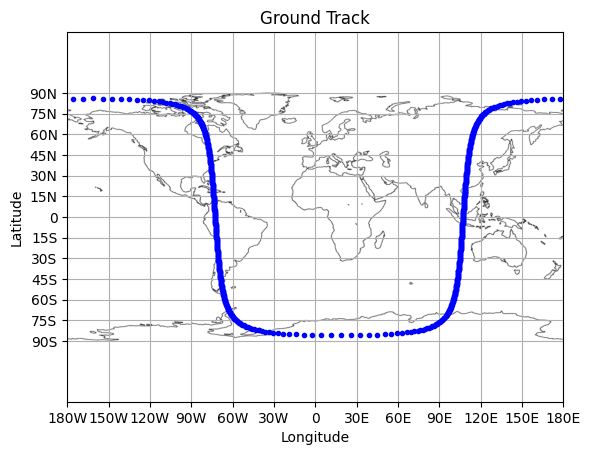

In [8]:
[x_scgi, y_scgi, z_scgi, lat, lon, h]= trajetoria(e=e, a=a, i=i, RAAN=RAAN, omega=omega, f=f, num_Orbitas=720, dt=1)

print('Latitude, Longitude e altitude Inicial:')
print(f'Latitude: {lat[0]} [º]')
print(f'Longitude: {lon[0]} [º]')
print(f'altitude: {h[0]} [m]')

plt.figure(1)
plt.title('Ground Track')
plt.plot(lon, lat,'.b')

# Ler a imagem

contour = mpimg.imread('mapaContorno.jpg')

# Configurar a exibição da imagem

plt.imshow(contour, extent=[-180, 180, -90, 90], cmap='gray')

# Configurar os rótulos dos eixos
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Definir limites dos eixos
plt.xlim([-180, 180])
plt.ylim([-90, 90])

# Definir as marcações dos eixos x
plt.xticks([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180],
        ['180W', '150W', '120W', '90W', '60W', '30W', '0', '30E', '60E', '90E', '120E', '150E', '180E'])

# Definir as marcações dos eixos y
plt.yticks([90, 75, 60, 45, 30, 15, 0, -15, -30, -45, -60, -75, -90],
        ['90N', '75N', '60N', '45N', '30N', '15N', '0', '15S', '30S', '45S', '60S', '75S', '90S'])

# Configurar a grade e proporções iguais
plt.axis('on')
plt.axis('equal')
plt.grid(True)
# Mostrar a imagem
plt.show()


Mas para a visualização 3D da óbita também pode-se:

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

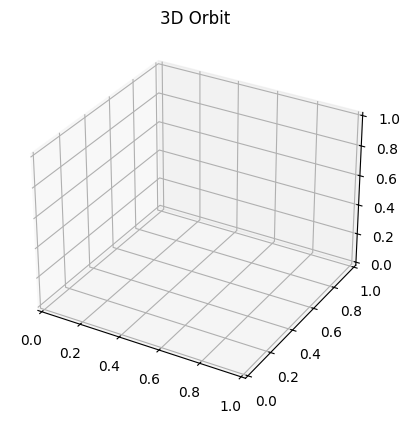

In [16]:

# syntax for 3-D projection
fig = plt.figure(2)
ax = fig.add_subplot(111, projection='3d')
ax.set_title('3D Orbit')

# Carregar a imagem do mapa de topografia
topomapa = mpimg.imread('topomapa.jpg')

# Definir os parâmetros da Terra

divisoes = 720

# Criar o ellipsoide
phi = np.linspace(0, 2 * np.pi, divisoes)
theta = np.linspace(0, np.pi, divisoes)
phi, theta = np.meshgrid(phi, theta)

x = raioEquatorialTerra * np.sin(theta) * np.cos(phi)
y = raioEquatorialTerra * np.sin(theta) * np.sin(phi)
z = raioPolarTerra * np.cos(theta)


# Mapear a imagem no ellipsoide
ax.plot_surface(x, y, z, cmap='gray', edgecolor='none', linewidth=0.1, linestyle=':')

# Adding labels to the axes

# Configurar os eixos
ax.set_xlim([-raioEquatorialTerra, raioEquatorialTerra])
ax.set_ylim([-raioEquatorialTerra, raioEquatorialTerra])
ax.set_zlim([-raioPolarTerra, raioPolarTerra])

# plotting
ax.plot3D(x_scgi, y_scgi, z_scgi, 'b.')

# Configurar a visualização
ax.view_init(30, -30)
plt.axis('on')
plt.axis('equal')
plt.grid(True)

# Mostrar a imagem
plt.show()

## Modelando uma Roda de Reação

Definindo o ciclom de trabalho:

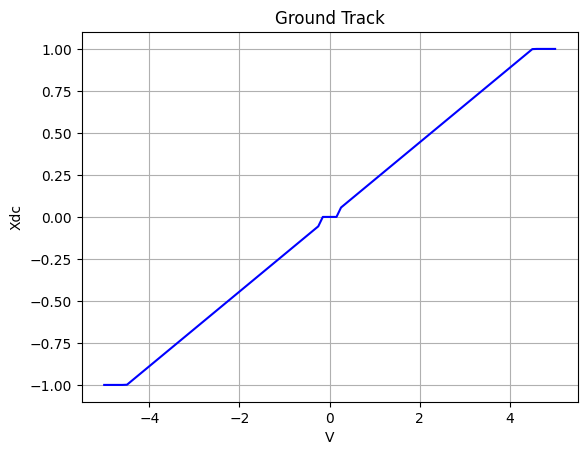

In [21]:
# Declarando e Alocando Variáveis 

# Parâmetros da Simulação
sim_stps = 100

# Parâmetros Roda de Reação 
V_RDR_Idle = 0.225 # [V]
V_RDR_Operacao = 4.5 # [V]
wRDR_max = 8000/9.5492965964254 # [rad/s]
wRDR_otm = 1000/9.5492965964254 # [rad/s]
alpha = 1-wRDR_otm/wRDR_max
r = 1
No = 3.84e-003 # [N.m]
N_C = 7.06e-004 # [N.m]
f = 1.21e-008*9.5492965964254 # [N.m/rad/s]
m_RDR = 0.137 # [kg]
r_RDR = 0.0435 # [m]
J_axial_RDR = 0.5*m_RDR*r_RDR**2 # [kg*m²]
alpha = 1-wRDR_otm/wRDR_max
N_C = 7.06e-004 # [N.m[]
f = 1.21e-006*9.5492965964254 # [N.m/rad/s]
# Alocando Variáveis
Xdc =  np.zeros((sim_stps)) 
N_Friccao = np.zeros((sim_stps)) # [N.m]
N_em = np.zeros((2,  sim_stps)) # [N.m]
N = np.zeros((2,  sim_stps)) # [N.m]

# Rotina 
Vapp = np.linspace(-5,5, sim_stps)

# Ciclo de Trabalho
for i in range(sim_stps):

    if abs(Vapp[i]) > V_RDR_Operacao:
        Xdc[i] = 1

    if abs(Vapp[i]) < V_RDR_Idle:
        Xdc[i] = 0

    if abs(Vapp[i]) >= V_RDR_Idle and abs(Vapp[i]) <= V_RDR_Operacao:
        coefs = np.polyfit([V_RDR_Idle, V_RDR_Operacao], [V_RDR_Idle/V_RDR_Operacao, 1], 1)
        Xdc[i] = np.polyval(coefs, abs(Vapp[i]))

    Xdc[i] = np.sign(Vapp[i])*Xdc[i]

#Resultado Ciclo de Trabalho
plt.figure(1)
plt.title('Ground Track')
plt.plot(Vapp, Xdc,'b')
# Configurar os rótulos dos eixos
plt.xlabel("V")
plt.ylabel("Xdc")
# Configurar a grade e proporções iguais
plt.axis('on')
plt.grid(True)
# Mostrar a imagem
plt.show()

Definindo as características do torque:

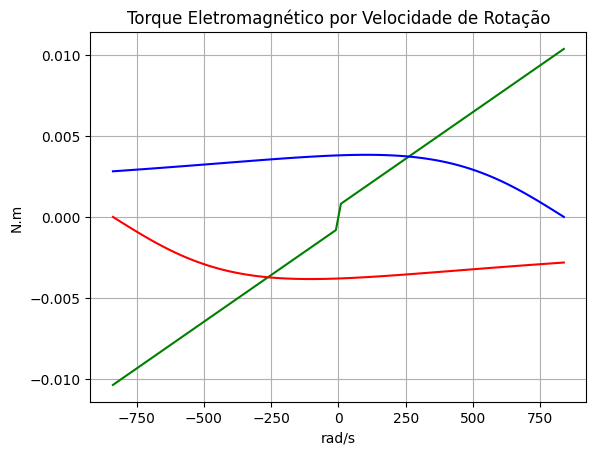

In [22]:
# Calculo do Torque por Velocidade de Rotação
Xdc = np.array([-1.0, 1.0])
wRDR = np.linspace(-wRDR_max*1.1, wRDR_max*1.1, sim_stps)

for j in range(len(Xdc)):
  for i in range(len(wRDR)):
    if abs(wRDR[i])>wRDR_max:
      wRDR[i] = np.sign(wRDR[i])*wRDR_max

    if Xdc[j]>0:
      r = 1-wRDR[i]/wRDR_max

    elif Xdc[j]<0:
      r = 1+wRDR[i]/wRDR_max

    N_Friccao[i] = N_C*np.sign(wRDR[i])+f*wRDR[i] # [N.m]
    N_em[j][i] = Xdc[j]*2*No*alpha*r/(alpha**2+r**2) # [N.m]
    N[j][i] = N_em[j][i]-N_Friccao[i] # N.m


# Resultado Torque por Velocidade de Rotação
plt.figure(2)
plt.title('Torque Eletromagnético por Velocidade de Rotação')
plt.plot(wRDR,N_Friccao,'g')
plt.plot(wRDR,N_em[1][:],'b')
plt.plot(wRDR,N_em[0][:],'r')
# Configurar os rótulos dos eixos
plt.xlabel("rad/s")
plt.ylabel("N.m")
# Configurar a grade e proporções iguais
plt.axis('on')
plt.grid(True)

plt.show()

## Controlando 3 Rodas de Reação:

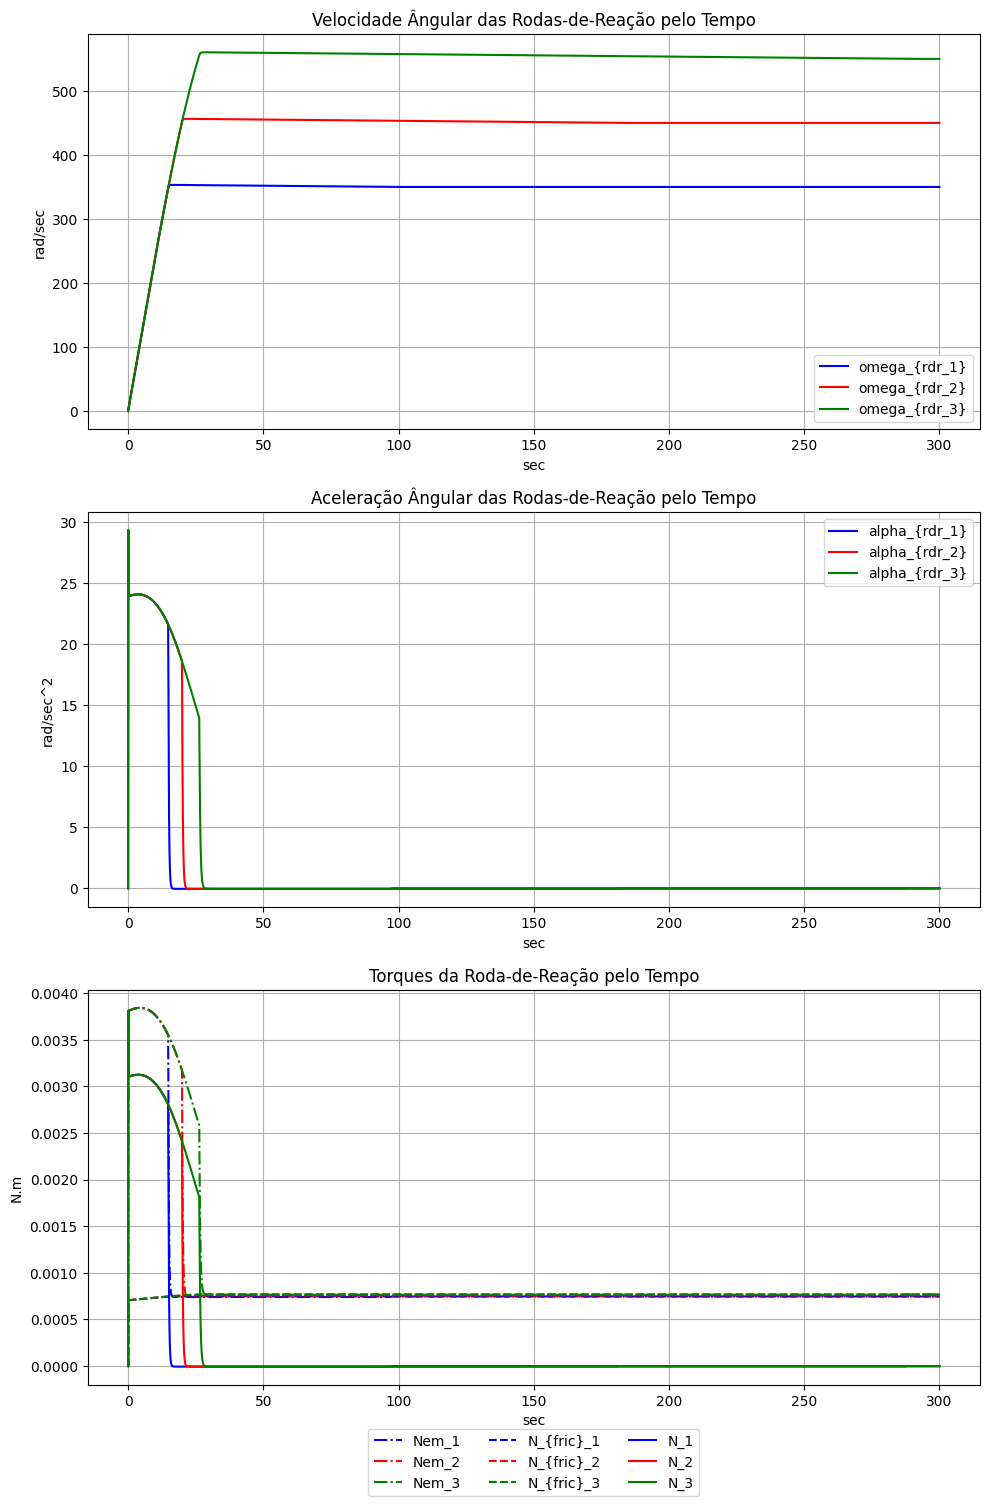

In [23]:
# Inicialização %
# Declarando e Alocando Variáveis %
# Parâmetros Roda de Reação
V_RDR_Idle = 0.225 # [V]
V_RDR_Operacao = 4.5 # [V]
wRDR_max = 8000/9.5492965964254 # [rad/s]
wRDR_Otima = 1000/9.5492965964254 # [rad/s]
alpha = 1-wRDR_Otima/wRDR_max
r = 1
Xdc = 0
No = 3.84e-003 # [N.m]
N_C = 7.06e-004 # [N.m]
f = 1.21e-008*9.5492965964254 # [N.m/rad/s]
m_RDR = 0.137 # [kg]
r_RDR = 0.0435 # [m]
J_axial_RDR = 0.5*m_RDR*r_RDR**2 # [kg*m²]
# Parâmetros da Simulação
sim_stps = 300*20
sim_time = 300 # [s
t = np.linspace(0,sim_time,sim_stps)
# Alocando e Declarando Variáveis
sequencia_rotacao = np.array([3, 2, 1])
N = np.zeros((3,sim_stps)) # [N.m]
N_Friccao = np.zeros((3,sim_stps)) # [N.m]
N_em = np.zeros((3,sim_stps)) # [N.m]
aRDR = np.zeros((3,sim_stps)) # [rad/s²]
e_wrdr = np.zeros((3,sim_stps))
wRDR = np.zeros((3,sim_stps))# [rad/s]
Se_wrdrdt=np.array([0, 0, 0])
# Afinação do Contole de Rotação da Roda de Reação
ref_wrdr = np.array([350, 450, 550])
Kp_wrdr = 0.6
Ki_wrdr = 0.6*2*0.001
Kd_wrdr = 0.6*0.125*0.001
# Rotina %
for i in range(sim_stps-1):
    dt = t[i+1]-t[i]
    for j in range(3):
        # Controle de Rotação Roda de Reação
        e_wrdr[j][i] = ref_wrdr[j]-wRDR[j][i]
        if i>1:
          de_wrdr = e_wrdr[j][i]-e_wrdr[j][i-1]
        else:
          de_wrdr = 0

        Se_wrdrdt[j] = Se_wrdrdt[j]+e_wrdr[j][i]*dt
        V_app = Kp_wrdr*e_wrdr[j][i]+Ki_wrdr*Se_wrdrdt[j]+Kd_wrdr*de_wrdr/dt # [V]
        # Atuador
        # Ciclo de Trabalho
        if abs(V_app)>V_RDR_Operacao:
            Xdc = 1
    
        if abs(V_app)<V_RDR_Idle:
            Xdc = 0
    
        if abs(V_app)>=V_RDR_Idle and abs(V_app)<=V_RDR_Operacao:
            coefs = np.polyfit([V_RDR_Idle, V_RDR_Operacao], [V_RDR_Idle/V_RDR_Operacao, 1], 1)
            Xdc = np.polyval(coefs, abs(V_app))

        Xdc = np.sign(V_app)*Xdc
        #Torques Roda de Reação
        if abs(wRDR[j][i])>wRDR_max:
            wRDR[j][i] = sign(wRDR[j][i])*wRDR_max # [rad/s]

        if Xdc>0:
            r = 1-wRDR[j][i]/wRDR_max # [rad/s]
        elif Xdc<0:
            r = 1+wRDR[j][i]/wRDR_max # [rad/s]

        N_Friccao[j][i+1] = N_C*np.sign(wRDR[j][i])+f*wRDR[j][i] # [N.m]
        N_em[j][i+1] = Xdc*2*No*alpha*r/(alpha**2+r**2) # [N.m]
        N[j][i+1] = N_em[j][i+1]-N_Friccao[j][i+1] # [N.m]
        aRDR[j][i+1] = N[j][i+1]/J_axial_RDR # [rad/seg²]
        wRDR[j][i+1] = wRDR[j][i]+aRDR[j][i+1]*dt # [rad/seg]


# Criar a figura
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Velocidade Ângular das Rodas-de-Reação pelo Tempo
axs[0].plot(t, wRDR[:][0], 'b', label='omega_{rdr_1}')
axs[0].plot(t, wRDR[:][1], 'r', label='omega_{rdr_2}')
axs[0].plot(t, wRDR[:][2], 'g', label='omega_{rdr_3}')
axs[0].set_title('Velocidade Ângular das Rodas-de-Reação pelo Tempo')
axs[0].set_xlabel('sec')
axs[0].set_ylabel('rad/sec')
axs[0].legend()
axs[0].grid(True)

# Aceleração Ângular das Rodas-de-Reação pelo Tempo
axs[1].plot(t, aRDR[:][0], 'b', label='alpha_{rdr_1}')
axs[1].plot(t, aRDR[:][1], 'r', label='alpha_{rdr_2}')
axs[1].plot(t, aRDR[:][2], 'g', label='alpha_{rdr_3}')
axs[1].set_title('Aceleração Ângular das Rodas-de-Reação pelo Tempo')
axs[1].set_xlabel('sec')
axs[1].set_ylabel('rad/sec^2')
axs[1].legend()
axs[1].grid(True)

# Torques da Roda-de-Reação pelo Tempo
axs[2].plot(t, N_em[:][0], '-.b', label='Nem_1')
axs[2].plot(t, N_em[:][1], '-.r', label='Nem_2')
axs[2].plot(t, N_em[:][2], '-.g', label='Nem_3')
axs[2].plot(t, N_Friccao[:][0], '--b', label='N_{fric}_1')
axs[2].plot(t, N_Friccao[:][1], '--r', label='N_{fric}_2')
axs[2].plot(t, N_Friccao[:][2], '--g', label='N_{fric}_3')
axs[2].plot(t, N[:][0], '-b', label='N_1')
axs[2].plot(t, N[:][1], '-r', label='N_2')
axs[2].plot(t, N[:][2], '-g', label='N_3')
axs[2].set_title('Torques da Roda-de-Reação pelo Tempo')
axs[2].set_xlabel('sec')
axs[2].set_ylabel('N.m')
axs[2].legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)
axs[2].grid(True)

# Ajustar o layout e mostrar a figura
plt.tight_layout()
plt.show()



### Dinâmica de corpo rígido em órbita

In [ ]:

import numpy as np
   
# Simulação
sim_period   = 720
num_steps = sim_period*100
dt = sim_period/num_steps

# Initial Conditions
# Position
r_SCGI = np.array([2.25526213722520e+006, -3.00492371279401e+006, -5.84397331427593e+006], dtype='float32')  # m

# Attitude
eul_ang = np.array([0.0, 0.0, 0.0], dtype='float32') 

# Linear Velocities
v_SCGI = np.array([-5.19923341417592e+003, 3.82519438208177e+003, -3.97333292224794e+003], dtype='float32')  # m/s

# Angular Velocities
w_ang = np.zeros((3,num_steps), dtype='float32')  # [rad/s]
                             

# Parâmetros do CubeSat
h_CubeSat = 30e-002  # [m]
l_CubeSat = 20e-002 # [m]
c_CubeSat = 10e-002 # [m]
m_CubeSat = 6 # [kg]
J_1 = 1/12*m_CubeSat*((l_CubeSat**2)+(h_CubeSat**2)) # [kg.m²]
J_2 = 1/12*m_CubeSat*((c_CubeSat**2)+(h_CubeSat**2)) # [kg.m²]
J_3 = 1/12*m_CubeSat*((l_CubeSat**2)+(c_CubeSat**2)) # [kg.m²]
J = np.diag([J_1, J_2, J_3]) # [kg.m²]

# Parâmetros Roda de Reação
V_RDR_Idle = 0.225 # [V]
V_RDR_Operacao = 4.5 # [V]
wRDR_max = 8000/9.5492965964254 # [rad/s]
wRDR_Otima = 1000/9.5492965964254; # [rad/s]
alpha = 1-wRDR_Otima/wRDR_max
r = 1
No = 3.84e-003 # [N.m]
N_C = 7.06e-004 # [N.m]
f = 1.21e-008*9.5492965964254 # [N.m/rad/s]
m_RDR = 0.137 # [kg]
r_RDR = 0.0435 # [m]
J_axial_RDR = 0.5*m_RDR*r_RDR**2 # [kg*m²]

# Declarando Variáveis
sim_time = np.zeros((1,num_steps), dtype='float32') 
theta_B_I_B = np.zeros((3,num_steps), dtype='float32') # [N.m]
T_res = np.zeros((3,num_steps), dtype='float32') # [N.m]
N_app = np.zeros((3,num_steps), dtype='float32')  # [N.m]
N_Friccao = np.zeros((3,num_steps), dtype='float32')  # [N.m]
N_em = np.zeros((3,num_steps), dtype='float32')  # [N.m]
aRDR = np.zeros((3,num_steps), dtype='float32')  # [rad/s²]
wRDR = np.zeros((3,num_steps), dtype='float32')  # [rad/s]

# Afinação do Controle de Atitude
ref_ang = np.array([0.0, 0.0, 0.0], dtype='float32') 
Se_angdt = np.array([0, 0, 0], dtype='float32') 
e_ang = np.zeros((3,num_steps), dtype='float32') 
Kp_ang = 15
Ki_ang = 15/(0.5*10)
Kd_ang = 15*0.125*10

# Afinação do Contole de Rotação da Roda de Reação
Vapp = np.array([0, 0, 0], dtype='float32') 
Xdc = np.array([0, 0, 0], dtype='float32') 
ref_wrdr = np.array([0.0, 0.0, 0.0])
Se_wrdrdt = np.array([0.0, 0.0, 0.0])
e_wrdr = np.zeros((3,num_steps), dtype='float32') 
Kp_wrdr = 0.6
Ki_wrdr = 0.6*2*0.001
Kd_wrdr = 0.6*0.125*0.001

# Data frame
data = []

try:
        
    for i in range(num_steps):
        
        for j in range(3):                    
            e_ang[j][i] = ref_ang[j]-theta_B_I_B[j][i]
            

            if (i>1):
                de_ang = e_ang[j][i]-e_ang[j][i-1]

            else:
                de_ang = 0
        
            Se_angdt[j] = Se_angdt[j]+e_ang[j][i]*dt
            ref_wrdr[j] = Kp_ang*e_ang[j][i]+Ki_ang*Se_angdt[j]+Kd_ang*de_ang/dt # [V]
            
            # Controle de Rotação Roda de Reação 
            e_wrdr[j][i] = ref_wrdr[j] - wRDR[j][i]
                                                    
            if (i>1):
                de_wrdr = e_wrdr[j][i]-e_wrdr[j][i-1]                        

            else:
                de_wrdr = 0

            Se_wrdrdt[j] = Se_wrdrdt[j]+e_wrdr[j][i]*dt
            Vapp[j] = Kp_wrdr*e_wrdr[j][i]+Ki_wrdr*Se_wrdrdt[j]+Kd_wrdr*de_wrdr/dt # [V]
            
            # Atuador
            # Ciclo de Trabalho
            if np.abs(Vapp[j])>V_RDR_Operacao:
                Xdc[j] = 1

            elif np.abs(Vapp[j])<V_RDR_Idle:
                Xdc[j] = 0
        
            elif np.abs(Vapp[j])>=V_RDR_Idle and np.abs(Vapp[j])<=V_RDR_Operacao:
                coefs = np.polyfit([V_RDR_Idle, V_RDR_Operacao], [V_RDR_Idle/V_RDR_Operacao, 1], 1)
                Xdc[j] = np.polyval(coefs, np.abs(Vapp[j]))
        
            Xdc[j] = np.sign(Vapp[j])*Xdc[j]
            
            #Torques Roda de Reação
            if np.abs(wRDR[j][i])>wRDR_max:
                wRDR[j][i] = np.sign(wRDR[j][i])*wRDR_max # [rad/s]

            if Xdc[j]>0:
                r = 1-wRDR[j][i]/wRDR_max # [rad/s]

            elif Xdc[j]<0:
                r = 1+wRDR[j][i]/wRDR_max # [rad/s]

            
            N_Friccao[j][i+1] = N_C*np.sign(wRDR[j][i])+f*wRDR[j][i] # [N.m]
            N_em[j][i+1] = Xdc[j]*2*No*alpha*r/(alpha**2+r**2) # [N.m]
            N_app[j][i+1] = (N_em[j][i+1]-N_Friccao[j][i+1]) # [N.m]
            aRDR[j][i+1] = N_app[j][i+1]/J_axial_RDR # [rad/s^2]                    
            wRDR[j][i+1] = wRDR[j][i]+aRDR[j][i+1]*dt # [rad/s]
            
            # Aplicação do torque de controle na planta
            w_ang
            T_x = N_app[0][i+1]
            T_y = N_app[1][i+1]
            T_z= N_app[2][i+1]

            pdot = (1/J_1)*((J_2-J_3)*w_ang[1][i]*w_ang[2][i]+T_x)
            qdot = (1/J_2)*((J_3-J_1)*w_ang[0][i]*w_ang[2][i]+T_y)
            rdot = (1/J_3)*((J_1-J_2)*w_ang[0][i]*w_ang[1][i]+T_z)

            w_ang[0][i+1] = w_ang[0][i]+pdot*dt
            w_ang[1][i+1] = w_ang[1][i]+pdot*dt
            w_ang[2][i+1] = w_ang[2][i]+pdot*dt

            theta_B_I_B[0][i+1] = theta_B_I_B[0][i]*w_ang[0][i+1]*dt
            theta_B_I_B[1][i+1] = theta_B_I_B[1][i]*w_ang[1][i+1]*dt
            theta_B_I_B[2][i+1] = theta_B_I_B[2][i]*w_ang[2][i+1]*dt
            sim_time[i+1]  = sim_time[i] +dt



            if np.abs(wRDR[0][i]) == 761.11:
                print('RDR eixo X Saturou')
            elif np.abs(wRDR[1][i]) == 761.11:
                print('RDR eixo Y Saturou')
            elif np.abs(wRDR[2][i]) == 761.11:
                print('RDR eixo Z Saturou')



            
        else:
            raise Exception('### ERROR: undefined flight stage!')
        

except ValueError as ve:
    print(f"Erro de valor encontrado: {ve}")

except KeyError as ke:
    print(f"Chave não encontrada no dicionário: {ke}")

except FileNotFoundError as fe:
    print(f"Arquivo não encontrado: {fe}")

except Exception as e:
    print(f"A simulação encontrou um erro: {type(e).__name__}: {e}")

finally:
    print('END')


plt.figure(1)
plt.plot(sim_time, np.rad2deg(theta_B_I_B[0][:]),':b')
plt.plot(sim_time, np.rad2deg(theta_B_I_B[1][:]),':r')
plt.plot(sim_time, np.rad2deg(theta_B_I_B[2][:]),':g')
plt.xlabel('Time [sec]')
plt.ylabel('Attitude [Deg]')
plt.title('Evolução da Atitude do Cubesat 6U')
plt.grid()

plt.figure(2)
plt.plot(sim_time, np.rad2deg(w_ang[0][:]),':b')
plt.plot(sim_time, np.rad2deg(w_ang[1][:]),':r')
plt.plot(sim_time np.rad2deg(w_ang[2][:]),':g')
plt.xlabel('Time [sec]')
plt.ylabel('Velocidade Angular [Deg/sec]')
plt.title('Velocidade Angular do Cubesat 6U')
plt.grid()

# Mostrar a imagem
plt.show()

# Salva data frame como csv
df.to_csv('cubesat_dataframe.csv', index=False)
